In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.applications import ResNet101
from keras.callbacks import ReduceLROnPlateau


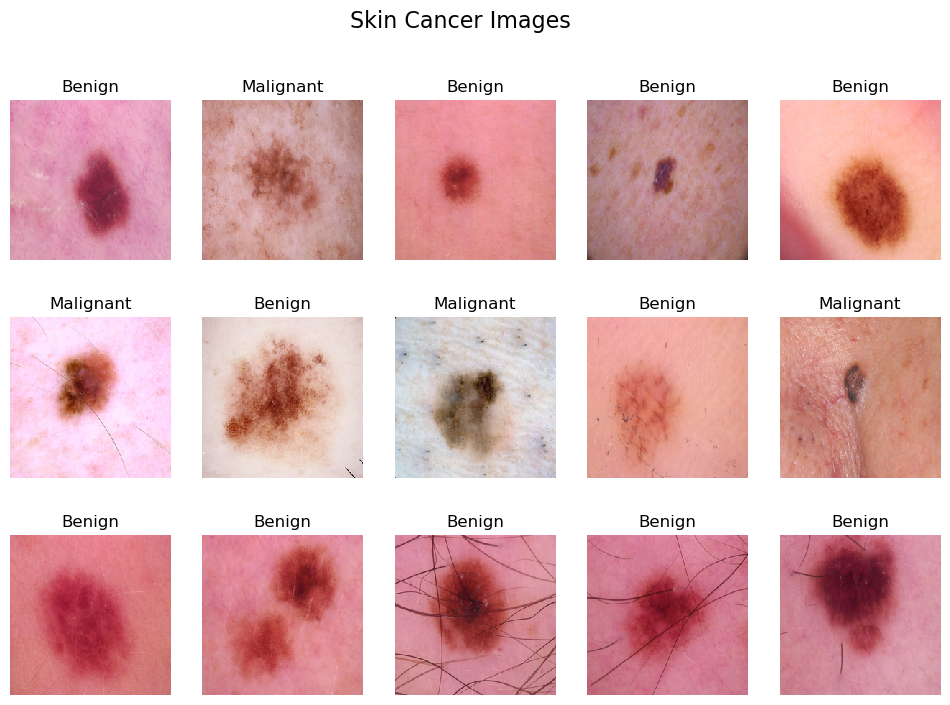

In [2]:
# Function to read and convert images to numpy arrays
read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))

# Define directories for image data
directory_benign_train = 'C:/Users/Yogesh S A/Desktop/skin cancer1/input/train/benign'
directory_malignant_train = 'C:/Users/Yogesh S A/Desktop/skin cancer1/input/train/malignant'
directory_benign_test = 'C:/Users/Yogesh S A/Desktop/skin cancer1/input/test/benign'
directory_malignant_test = 'C:/Users/Yogesh S A/Desktop/skin cancer1/input/test/malignant'

# Load train images
img_benign_train = [read(os.path.join(directory_benign_train, filename)) for filename in os.listdir(directory_benign_train)]
img_malignant_train = [read(os.path.join(directory_malignant_train, filename)) for filename in os.listdir(directory_malignant_train)]

# Load test images
img_benign_test = [read(os.path.join(directory_benign_test, filename)) for filename in os.listdir(directory_benign_test)]
img_malignant_test = [read(os.path.join(directory_malignant_test, filename)) for filename in os.listdir(directory_malignant_test)]

# Convert lists of images to NumPy arrays
X_benign_train = np.array(img_benign_train, dtype='uint8')
X_malignant_train = np.array(img_malignant_train, dtype='uint8')

X_benign_test = np.array(img_benign_test, dtype='uint8')
X_malignant_test = np.array(img_malignant_test, dtype='uint8')

# Create labels
y_benign_train = np.zeros(X_benign_train.shape[0])
y_malignant_train = np.ones(X_malignant_train.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Merging data to form complete training and test sets
X_train = np.concatenate((X_benign_train, X_malignant_train), axis=0) 
y_train = np.concatenate((y_benign_train, y_malignant_train), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

# Shuffle the data
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)

X_train = X_train[s1]
y_train = y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)

X_test = X_test[s2]
y_test = y_test[s2]

# Visualize a subset of the images
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
fig.suptitle('Skin Cancer Images', fontsize=16)

for i, ax in enumerate(axes.flat):
    if y_train[i] == 0:
        label = 'Benign'
    else:
        label = 'Malignant'
    
    ax.imshow(X_train[i], interpolation='nearest')
    ax.set_title(label)
    ax.axis('off')

plt.show()


In [3]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Create ResNet-101 base model
resnet101_base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def build_resnet101_model(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential()

    # Add ResNet-101 base model
    model.add(resnet101_base_model)
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the ResNet-101 model
resnet101_model = build_resnet101_model()


In [4]:
# Create a learning rate annealer callback
learning_rate_annealer = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=1e-7)

# Train the ResNet-101 model with a progress bar
history_resnet101 = resnet101_model.fit(X_train,
                                        y_train,
                                        validation_split=0.2,
                                        epochs=50,
                                        batch_size=64,
                                        verbose=1,  # Set verbose to 1 to display a progress bar
                                        callbacks=[learning_rate_annealer])


Epoch 1/50
 7/33 [=====>........................] - ETA: 10:03 - loss: 4.4433 - accuracy: 0.6674

KeyboardInterrupt: 

In [ ]:
# Plot model accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet101.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet101.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet-101 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet101.history['loss'], label='Training Loss')
plt.plot(history_resnet101.history['val_loss'], label='Validation Loss')
plt.title('ResNet-101 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the ResNet-101 model on the test data
y_pred_resnet101 = np.argmax(resnet101_model.predict(X_test), axis=-1)
y_true_resnet101 = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy_resnet101 = accuracy_score(y_true_resnet101, y_pred_resnet101)

print("ResNet-101 Test accuracy:", accuracy_resnet101)
